In [3]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from agents import *
from environments import RaceTrack
from IPython.display import Image
from multiproc_utils import TrainPool

In [2]:
track = RaceTrack(RaceTrack.track_challenge)
track.set_eval()

#n = 5
alpha = 0.5
epsilon = 0.1
final_alpha = 0.0
final_epsilon = 0.0
selector = EpsilonGreedy(epsilon=epsilon)

alpha_schedule = SigmoidSchedule(
    ["learner", "alpha"],
    alpha,
    0.0,
)
epsilon_schedule = LinearSchedule(
    ["selector", "epsilon"],
    epsilon,
    final_epsilon,
)

In [3]:
learner = NStepTreeBackup(n=2, alpha=alpha)
tb2_agent = Agent(
    num_states=track.num_states,
    num_actions=track.num_actions,
    selector=selector,
    learner=learner,
    schedules=[
        alpha_schedule,
        epsilon_schedule,
    ],
)

learner = NStepTreeBackup(n=3, alpha=alpha)
tb3_agent = Agent(
    num_states=track.num_states,
    num_actions=track.num_actions,
    selector=selector,
    learner=learner,
    schedules=[
        alpha_schedule,
        epsilon_schedule,
    ],
)

In [4]:
tb2_trainer = Trainer(agent=tb2_agent, env=track)
tb3_trainer = Trainer(agent=tb3_agent, env=track)

In [5]:
num_episodes = 10_000

pool = TrainPool([tb2_trainer, tb3_trainer], num_episodes)
updates = pool()

Training complete!
Training complete!
Receiving!
Receiving!


In [6]:
#Q, lens, rets = updates[0]
lens, rets = updates[0]
#tb2_agent.Q = Q
tb2_agent.ep_lengths = lens
tb2_agent.ep_returns = rets
#Q, lens, rets = updates[1]
lens, rets = updates[1]
#tb3_agent.Q = Q
tb3_agent.ep_lengths = lens
tb3_agent.ep_returns = rets

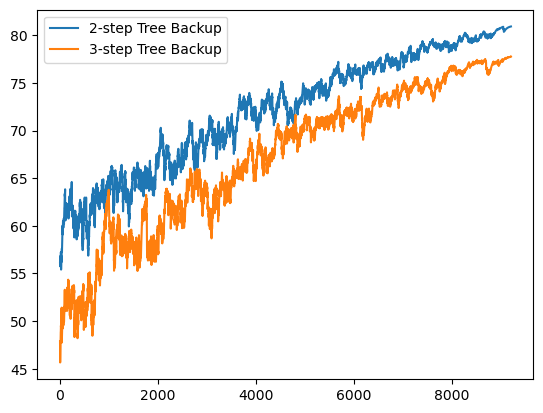

In [7]:
tb2_trailing_returns = np.zeros_like(tb2_agent.ep_returns)
tb2_trailing_returns[0] = tb2_agent.ep_returns[0]

step_size = 1 / 70
for i in range(1, len(tb2_agent.ep_returns)):
    tb2_trailing_returns[i] = step_size * tb2_agent.ep_returns[i] + (1 - step_size) * tb2_trailing_returns[i-1]

tb3_trailing_returns = np.zeros_like(tb3_agent.ep_returns)
tb3_trailing_returns[0] = tb3_agent.ep_returns[0]

for i in range(1, len(tb3_agent.ep_returns)):
    tb3_trailing_returns[i] = step_size * tb3_agent.ep_returns[i] + (1 - step_size) * tb3_trailing_returns[i-1]

start_from = 800
plt.plot(tb2_trailing_returns[start_from:], label=f"2-step Tree Backup")
plt.plot(tb3_trailing_returns[start_from:], label=f"3-step Tree Backup")
plt.legend()
plt.show()

## Dyna-Q testing ground

In [29]:
dyna_test_track = RaceTrack(RaceTrack.track_easy)

num_states = dyna_test_track.num_states
num_actions = dyna_test_track.num_actions
selector=EpsilonGreedy(0.01)

dyna_q = Agent(
    num_states=num_states,
    num_actions=num_actions,
    selector=selector,
    learner=QLearning(0.05),
    planner=Dyna(
        plan_steps=1,
        selector=selector,
        learner=QLearning(0.05)
    )
)

q = Agent(
    num_states=num_states,
    num_actions=num_actions,
    selector=selector,
    learner=QLearning(0.05),
)

dyna_trainer = Trainer(dyna_q, dyna_test_track)
q_trainer = Trainer(q, dyna_test_track)

In [30]:
num_episodes = 40

dyna_trainer.train(num_episodes)
q_trainer.train(num_episodes)

Episodes:   0%|          | 0/40 [00:00<?, ?it/s]

Episodes:   0%|          | 0/40 [00:00<?, ?it/s]

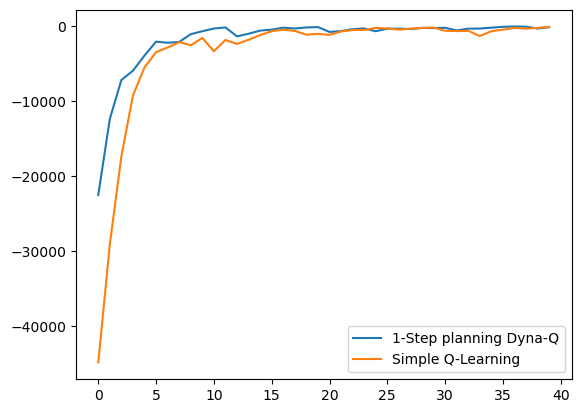

In [31]:
dyna_tr = np.zeros_like(dyna_q.ep_returns)
dyna_tr[0] = dyna_q.ep_returns[0]

step_size = 1 / (num_episodes // 20)
for i in range(1, len(dyna_q.ep_returns)):
    dyna_tr[i] = step_size * dyna_q.ep_returns[i] + (1 - step_size) * dyna_tr[i-1]

q_tr = np.zeros_like(q.ep_returns)
q_tr[0] = q.ep_returns[0]

for i in range(1, len(q.ep_returns)):
    q_tr[i] = step_size * q.ep_returns[i] + (1 - step_size) * q_tr[i-1]

start_from = 0
plt.plot(dyna_tr[start_from:], label=f"1-Step planning Dyna-Q")
plt.plot(q_tr[start_from:], label=f"Simple Q-Learning")
plt.legend()
plt.show()